## Prerequisites

We will pull a repo which uses the model proposed in the paper. The original .ipynb uses caffe librarie which is really problematic, so instead in the code avalibale in this library, we use one method of opencv to use the models of the paper directly. 

In [ ]:
!git clone https://github.com/iam-smjamilsagar/Age-And-Gender-Detection.git

Cloning into 'Age-And-Gender-Detection'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 29 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


We access the directory that we just downloaded.

In [ ]:
%cd Age-And-Gender-Detection

/content/Age-And-Gender-Detection


In that directory, we will download a file which contains the age net model, the gender model and a face detector. The first two correspond to the trained models created by the authors of the paper. The face tracker was created by someone else. The file is big, thus we need to unzip it in the working directory.

In [ ]:
!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
!unzip modelNweight.zip

Downloading...
From: https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
To: /content/Age-And-Gender-Detection/modelNweight.zip
100% 86.2M/86.2M [00:00<00:00, 146MB/s]
Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  


#Running the model

We will import the needed libraries. The google colab patch is needed to work with opencv in google colab. 

In [ ]:
import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow

The function getFaceBox draws a rectange over the face and defines things such as the confidence threshold and the characteristics of the frame. Notice that this is where we call our models and we create the age gender detector. 

In [ ]:
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

"""This is the part where we put our models. If run locally, make sure you have the models in the same working directory."""

faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"

ageProto = "modelNweight/age_deploy.prototxt"
ageModel = "modelNweight/age_net.caffemodel"

genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        label = "{},{}".format(gender, age)
        print(label)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv.LINE_AA)
    return frameFace

We will import images and test our first result that everything is in order. 

Male,(15-20)


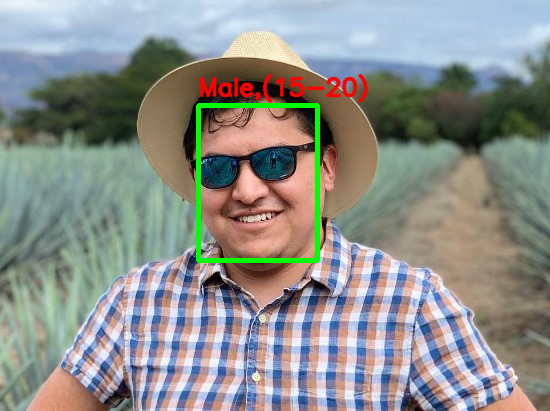

In [ ]:
input = cv.imread("{YOUR IMAGE GOES HERE}.jpg")
output = age_gender_detector(input)
cv2_imshow(output)